## 머신러닝 적용기 2

## 라이브러리 로드

In [1]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy, 시각화를 위한 seaborn, matplotlib 을 로드합니다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 110

## 시각화를 위한 폰트 설정

In [3]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family


# style 설정은 꼭 폰트설정 위에서 합니다.
# style 에 폰트 설정이 들어있으면 한글폰트가 초기화 되어 한글이 깨집니다.
plt.style.use("seaborn")
# 폰트설정
plt.rc("font", family=get_font_family())

# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

<AxesSubplot:title={'center':'한글'}>

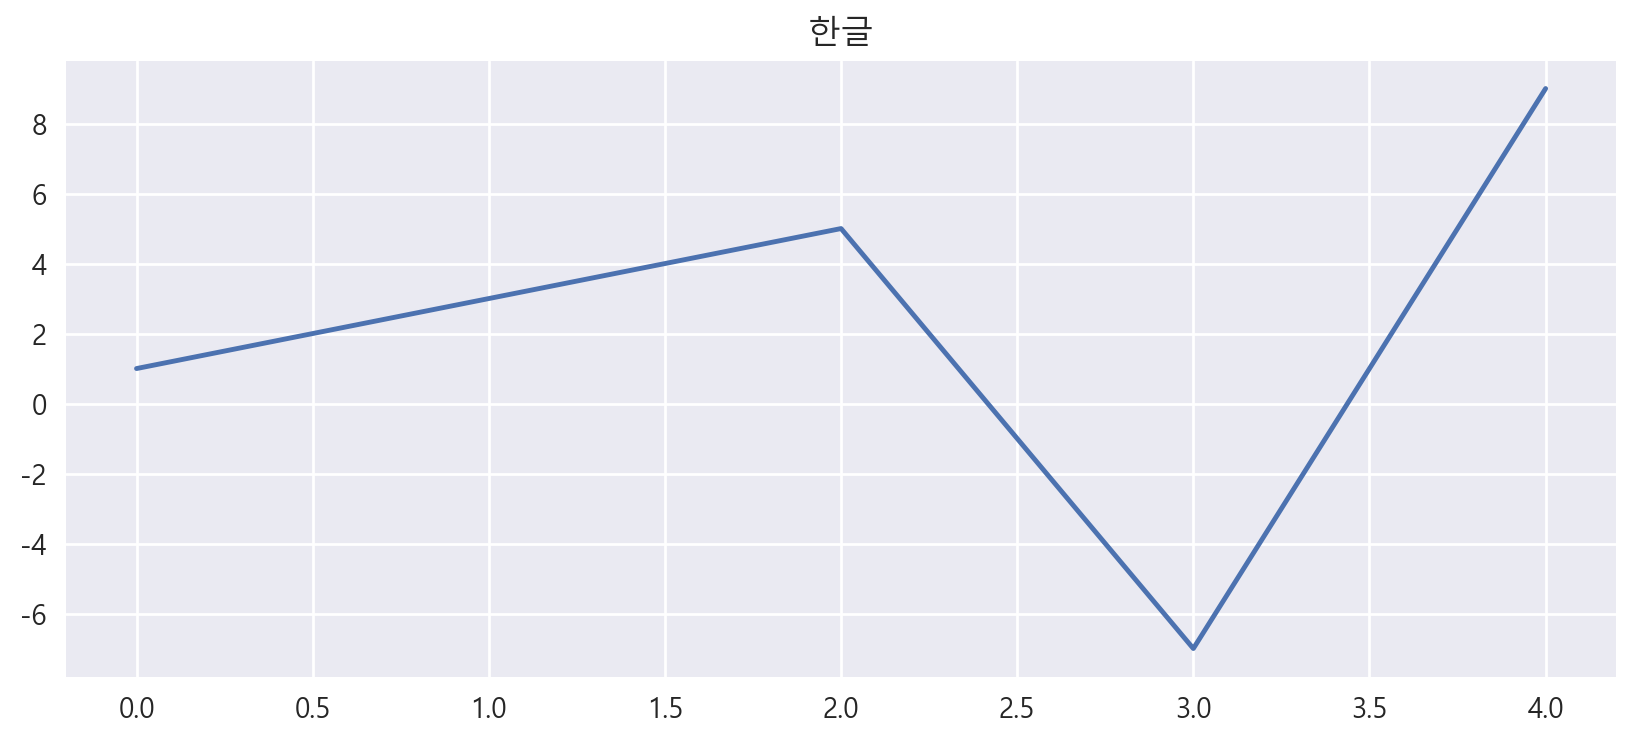

In [4]:
pd.Series([1, 3, 5, -7, 9]).plot(title="한글", figsize=(10, 4))

## 데이터 로드

In [5]:
# 학습, 예측 데이터셋을 불러옵니다.
train = pd.read_csv("../../data/train_df_1012.csv")
test = pd.read_csv("../../data/test_df_1012.csv")
train.shape, test.shape

((54314, 4), (23405, 3))

In [6]:
train['분류'].value_counts().head(5)

지역          26850
경제:부동산       3447
사회:사건_사고     2545
경제:반도체       2309
사회:사회일반      1457
Name: 분류, dtype: int64

## 전처리를 위한 데이터 병합
* 학습, 예측 세트를 똑같이 전처리 해주기 위해 각각 같은 방법을 적용해 줄 수도 있지만
* 두 데이터를 병합해서 전처리를 해주고 다시 나눠주겠습니다.

## concat
<img src="https://pandas.pydata.org/docs/_images/08_concat_row.svg" width="500">

In [7]:
# 전처리를 위해 데이터 병합
df = pd.concat([train, test], axis=0)
train.shape, test.shape, df.shape

((54314, 4), (23405, 3), (77719, 4))

## 정답값 빈도수
* train 에서 제공하는 정답값의 빈도수

## 학습, 예측 데이터셋 분리
* 전처리가 되었다면 concat 으로 합쳐주었던 데이터프레임을 다시 학습과 예측 데이터셋으로 분리합니다.

In [8]:
# 정답값으로 사용할 topic_idx 를 변수에 담아 재사용 합니다.
label_name = "분류"

In [9]:
# label_name 을 기준으로 학습, 예측 세트를 분리합니다.
# label_name 이 있다면 학습 세트, 없다면 예측 세트가 됩니다.
# df_train
# df_test
df_train = df[df["분류"].notnull()].copy()
df_test = df[df["분류"].isnull()].copy()
df_train.shape, df_test.shape

((54314, 4), (23405, 4))

제목 + 키워드

In [10]:
import re

def clean_text(text):
    # 쉼표와 따옴표 제거
    text = re.sub(r'[,\']', '', text)
    # 한글 단어만 남기고 나머지 문자 제거
    text = re.sub(r'[^가-힣\s]', '', text)
    return text

# '제목' 컬럼에 대해 처리
df_train['제목'] = df_train['제목'].apply(clean_text)
df_test['제목'] = df_test['제목'].apply(clean_text)

In [11]:
# 데이터 준비
df_train['키워드'] = df_train['제목'] + ' ' + df_train['키워드']
df_test['키워드'] = df_test['제목'] + ' ' + df_test['키워드']

In [12]:
# 학습, 예측에 사용할 문제를 나눕니다.
# 기출문제(X_train)과 실전문제(X_test)를 나눈다고 볼 수 있습니다.
# X_train_text
# X_test_text
X_train_text = df_train["키워드"]
X_test_text = df_test["키워드"]
X_train_text.shape, X_test_text.shape

((54314,), (23405,))

In [13]:
# 기출문제의 정답을 만들어 줍니다.
# 잘 나뉘었는지 정닶 값의 빈도수를 확인해 봅니다.
y_train = df_train[label_name]
y_train.shape

(54314,)

In [14]:
# 테스트의 정답은 모두 결측치 입니다.
# Dacon 사이트에 예측 값을 제출해야 맞고 틀린 갯수를 알 수 있습니다.
y_test =  df_test[label_name]
y_test.shape

(23405,)

## 벡터화
* 머신러닝이나 딥러닝 알고리즘은 문자를 이해할 수 없습니다. 내부에서는 수치 계산이 이루어지기 때문에 문자를 숫자로 변경해 주어야 합니다.


### TF-IDF(Term Frequency - Inverse Document Frequency)

정보 검색과 텍스트 마이닝에서 이용하는 가중치로, 여러 문서로 이루어진 문서군이 있을 때 어떤 단어가 특정 문서 내에서 얼마나 중요한 것인지를 나타내는 통계적 수치이다. 문서의 핵심어를 추출하거나, 검색 엔진에서 검색 결과의 순위를 결정하거나, 문서들 사이의 비슷한 정도를 구하는 등의 용도로 사용할 수 있다.

TF(단어 빈도, term frequency)는 특정한 단어가 문서 내에 얼마나 자주 등장하는지를 나타내는 값으로, 이 값이 높을수록 문서에서 중요하다고 생각할 수 있다. 하지만 단어 자체가 문서군 내에서 자주 사용 되는 경우, 이것은 그 단어가 흔하게 등장한다는 것을 의미한다. 이것을 DF(문서 빈도, document frequency)라고 하며, 이 값의 역수를 IDF(역문서 빈도, inverse document frequency)라고 한다. TF-IDF는 TF와 IDF를 곱한 값이다.

IDF 값은 문서군의 성격에 따라 결정된다. 예를 들어 '원자'라는 낱말은 일반적인 문서들 사이에서는 잘 나오지 않기 때문에 IDF 값이 높아지고 문서의 핵심어가 될 수 있지만, 원자에 대한 문서를 모아놓은 문서군의 경우 이 낱말은 상투어가 되어 각 문서들을 세분화하여 구분할 수 있는 다른 낱말들이 높은 가중치를 얻게 된다.

\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \times (\log\big(\frac{N + 1}{N_w + 1}\big) + 1)
\end{equation*}


* 출처 : [tf-idf - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/Tf-idf)

In [15]:
# TfidfVectorizer 로 벡터화 합니다.
# fit 으로 변환할 어휘를 학습합니다.
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvect = TfidfVectorizer(ngram_range=(1, 1), max_df=1.0, min_df=2)
tfidfvect.fit(X_train_text)

TfidfVectorizer(min_df=2)

In [16]:
# transform
# X_train
# X_test
X_train = tfidfvect.transform(X_train_text)
X_test = tfidfvect.transform(X_test_text)
X_train.shape, X_test.shape

((54314, 119241), (23405, 119241))

In [17]:
# X_train의 내용을 확인합니다.
print(X_train)

  (0, 116715)	0.09839426105137163
  (0, 114038)	0.07214034871322039
  (0, 113701)	0.0755837726598354
  (0, 111993)	0.06199099858379091
  (0, 109000)	0.05177737543555633
  (0, 108979)	0.08332851087572185
  (0, 107723)	0.07085989223976578
  (0, 104887)	0.07223182519983098
  (0, 104573)	0.3671812442667468
  (0, 101020)	0.11540168059918336
  (0, 93810)	0.04222935216015427
  (0, 90099)	0.08450829709811443
  (0, 88566)	0.08332851087572185
  (0, 86838)	0.052341494946543964
  (0, 85703)	0.05148361228001083
  (0, 82455)	0.3987428945640236
  (0, 80812)	0.17969691635799787
  (0, 79696)	0.10127585892848966
  (0, 77555)	0.05095362883474024
  (0, 77257)	0.10127585892848966
  (0, 77141)	0.09433287695186104
  (0, 76481)	0.09839426105137163
  (0, 74053)	0.2749927589364883
  (0, 73153)	0.0854943324892824
  (0, 71349)	0.060778208688486865
  :	:
  (54313, 34856)	0.12272315687961738
  (54313, 31187)	0.03551870187154464
  (54313, 29521)	0.10386808336994144
  (54313, 28355)	0.09333920558501384
  (54313, 2640

In [18]:
# 단어 사전 feature_names
# tfidfvect.vocabulary_
feature_names = tfidfvect.get_feature_names_out()
len(feature_names)

119241

In [19]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# 희소 행렬을 사용하여 TF-IDF 값을 단어별로 더합니다.
df_vocab = pd.DataFrame.sparse.from_spmatrix(X_train, columns=feature_names)
df_vocab = df_vocab.sum(axis=0).to_frame(name='sum')
df_vocab

,sum
00065,0.181120
050학급,0.158054
0승,0.281738
0완승,0.142117
1000가지,0.189758
...,...
龍仁,0.112307
陸軍副將正一品大勳位,0.084235
輪圖,0.133274
李中仁,0.185317


In [20]:
# df_vocab의 열 이름 확인
print(df_vocab.columns)

# TF-IDF 합계 값이 높은 상위 10개 어휘
df_vocab_top = df_vocab['sum'].nlargest(10)
df_vocab_top

Index(['sum'], dtype='object')


반도체    1221.466494
사업     1036.650797
조성      711.019929
도시      644.544680
확진자     631.353952
산업      616.421564
기업      588.329062
단지      579.626959
추진      541.601530
시설      538.665895
Name: sum, dtype: float64

<AxesSubplot:>

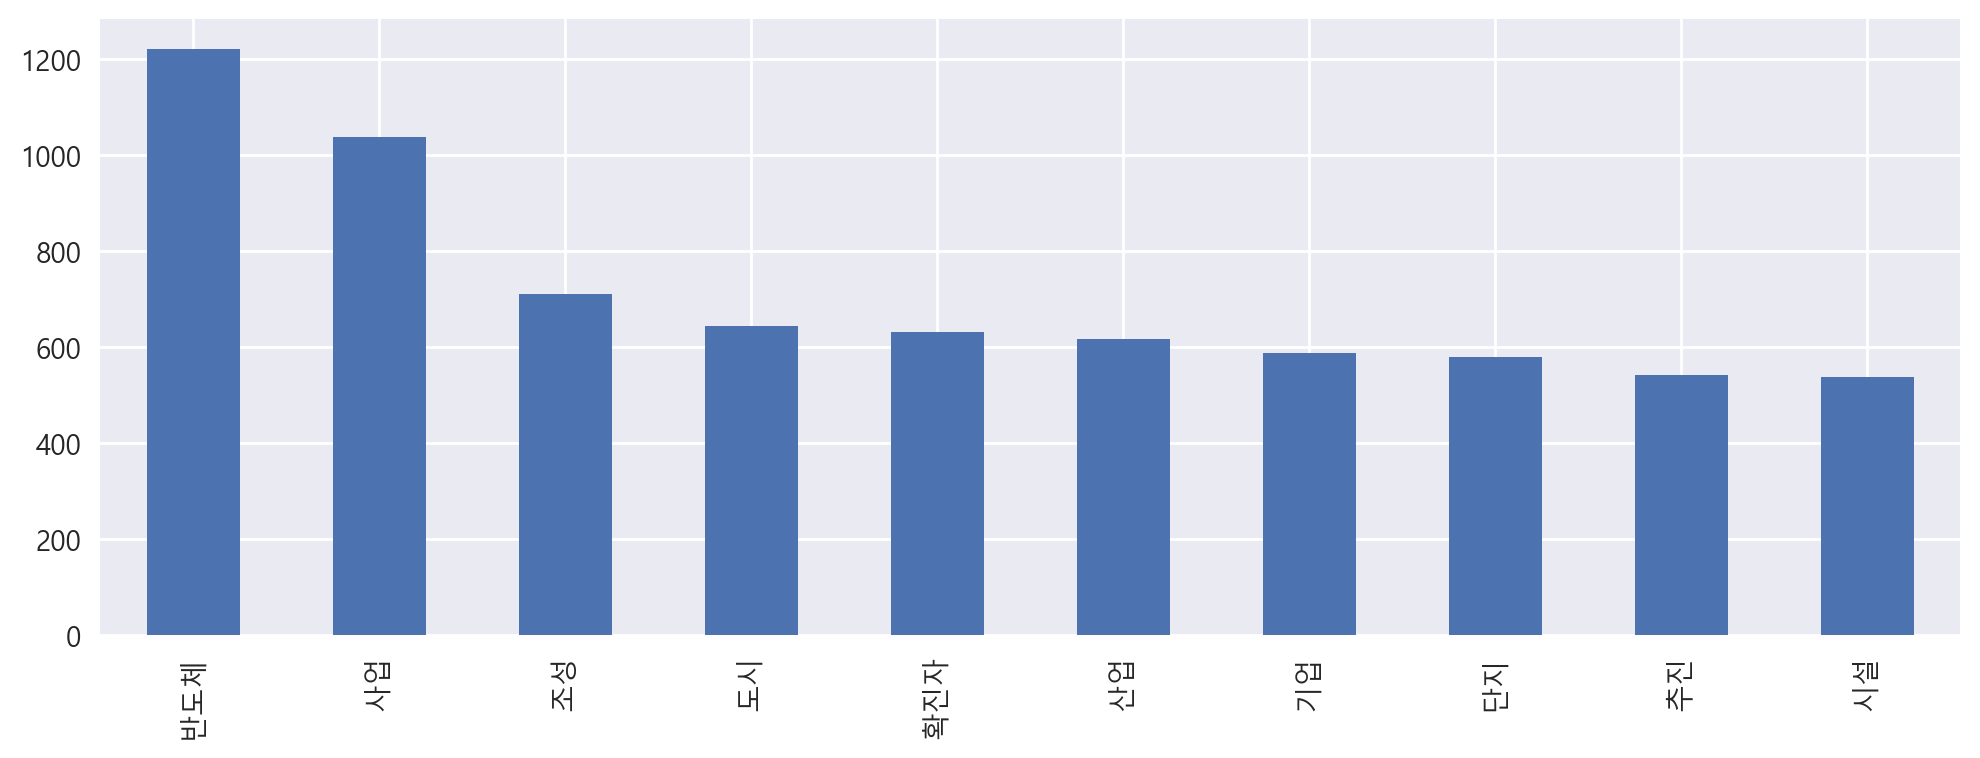

In [21]:
# 위에서 구한 빈도수를 그래프로 그립니다.
df_vocab_top.plot.bar(figsize=(12, 4))

## optuna

In [ ]:
# import optuna
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import f1_score
# from sklearn.model_selection import train_test_split

# # 데이터셋 분할
# X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, df_train[label_name], test_size=0.2, random_state=42)

# def objective(trial):
#     param = {
#         'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
#         # 'max_depth': trial.suggest_int('max_depth', 3, 30),
#         # 'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         # 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
#         # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
#         # 'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
#         'random_state': RANDOM_STATE,
#         'n_jobs': -1
#     }

#     model = RandomForestClassifier(**param)
#     model.fit(X_train_split, y_train_split)
#     y_val_pred = model.predict(X_val_split)
    
#     score = f1_score(y_val_split, y_val_pred, average='macro')
    
#     return score

# # 하이퍼 파라미터 튜닝
# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
# study.optimize(objective, n_trials=100)

# print('Best trial: score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

# # 최적의 하이퍼파라미터로 모델 정의
# best_params = study.best_trial.params
# model = RandomForestClassifier(**best_params)

# # 모델 학습
# model.fit(X_train, df_train[label_name])

# # 모델 예측
# y_train_predict = model.predict(X_train_split)
# y_val_predict = model.predict(X_val_split)

# # 모델 평가
# train_f1_score = f1_score(y_train_split, y_train_predict, average='macro')
# val_f1_score = f1_score(y_val_split, y_val_predict, average='macro')

# print(f'Train F1 Score: {train_f1_score}')
# print(f'Validation F1 Score: {val_f1_score}')

## 모델링

## 교차 검증

<img src="https://i.imgur.com/x9M8zpI.png" width="600">

In [22]:
# RandomForestClassifier 를 불러옵니다.
from sklearn.ensemble import RandomForestClassifier

# 모델을 정의합니다.
model = RandomForestClassifier(n_estimators=500,
                               n_jobs=-1, 
                               random_state=RANDOM_STATE)

# 모델을 학습합니다.
model.fit(X_train, df_train[label_name])

# 모델을 출력합니다.
model

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=110)

In [23]:
# cross_val_predict 로 교차 검증을 합니다.
from sklearn.model_selection import cross_val_predict

y_valid_predict = cross_val_predict(model, X_train, y_train, cv=3)
y_valid_predict

array(['문화:전시_공연', '지역', '지역', ..., '지역', '지역', '지역'], dtype=object)

### 교차 검증 정확도

In [24]:
# 교차 검증 결과 
y_valid_predict[:10]

array(['문화:전시_공연', '지역', '지역', '지역', '지역', '지역', '정치:국회_정당', '경제:금융_재테크',
       '지역', '지역'], dtype=object)

In [25]:
from sklearn.metrics import f1_score

# 교차 검증 결과 점수를 구해봅니다.
# 모의고사를 보고 채점해 보는 과정과 유사합니다.
# valid_accuracy
f1_score = f1_score(y_train, y_valid_predict, average='macro')
print(f1_score)

0.5525199095928678


In [26]:
# df_accuracy 로 정답여부 컬럼을 만듦
df_accuracy = pd.DataFrame({"train": y_train, 
                            "predict": y_valid_predict, 
                            "accuracy" : y_train == y_valid_predict})
df_accuracy

,train,predict,accuracy
0,문화:전시_공연,문화:전시_공연,True
1,지역,지역,True
2,지역,지역,True
3,지역,지역,True
4,국제,지역,False
...,...,...,...
54309,국제,지역,False
54310,사회:교육_시험,경제:산업_기업,False
54311,지역,지역,True
54312,지역,지역,True


In [27]:
# 각 분류별 정확도를 구합니다.
df_group_accuracy = df_accuracy.groupby("train")["accuracy"].mean()

# 분류별 정확도 출력
df_group_accuracy

train
IT_과학:IT_과학일반    0.214876
IT_과학:과학         0.390698
IT_과학:모바일        0.513158
IT_과학:보안         0.451613
IT_과학:인터넷_SNS    0.344538
IT_과학:콘텐츠        0.368750
경제:경제일반          0.310789
경제:금융_재테크        0.552147
경제:무역            0.723118
경제:반도체           0.818969
경제:부동산           0.836960
경제:산업_기업         0.399718
경제:서비스_쇼핑        0.514212
경제:외환            0.666667
경제:유통            0.402397
경제:자동차           0.576433
경제:자원            0.410112
경제:증권_증시         0.500000
경제:취업_창업         0.669039
국제               0.393293
문화:문화일반          0.252381
문화:미술_건축         0.412281
문화:방송_연예         0.488024
문화:생활            0.140000
문화:영화            0.115385
문화:요리_여행         0.217391
문화:음악            0.376147
문화:전시_공연         0.534431
문화:종교            0.267442
문화:출판            0.240816
문화:학술_문화재        0.545000
사회:교육_시험         0.435045
사회:날씨            0.378151
사회:노동_복지         0.507937
사회:미디어           0.166667
사회:사건_사고         0.926916
사회:사회일반          0.236102
사회:여성            0.350844
사회:의료_

## 학습

In [95]:
# fit 으로 학습시킵니다.
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [113]:
X_train

<54314x107056 sparse matrix of type '<class 'numpy.float64'>'
	with 4697714 stored elements in Compressed Sparse Row format>

## 예측

In [96]:
# 실전 시험과 유사합니다. 정답 없이 문제만 넣고 풀어서 예측합니다.
# predict로 예측합니다. 
y_predict = model.predict(X_test)
y_predict[:10]

array(['지역', '사회:사회일반', '지역', '경제:취업_창업', '지역', '경제:반도체', '경제:경제일반', '국제',
       '사회:사건_사고', '경제:자원'], dtype=object)

## 답안지 양식 로드

In [97]:
# sample_submission 파일을 불러옵니다.
# Dacon 에 제출할 답안지 양식입니다.
submit = pd.read_csv("../../data/sample_submission.csv")
submit.head()

,ID,분류
0,TEST_00000,지역
1,TEST_00001,지역
2,TEST_00002,지역
3,TEST_00003,지역
4,TEST_00004,지역


In [98]:
# 답안지에 정답을 옮겨 적음
submit["분류"] = y_predict
submit.head()

,ID,분류
0,TEST_00000,지역
1,TEST_00001,사회:사회일반
2,TEST_00002,지역
3,TEST_00003,경제:취업_창업
4,TEST_00004,지역


In [99]:
valid_accuracy = valid_accuracy.mean()

In [100]:
file_name = f"submit_{valid_accuracy}.csv"
file_name

'submit_0.7648856648377951.csv'

In [101]:
# 제출을 위해 파일로 저장합니다.
submit.to_csv(file_name, encoding='UTF-8-sig', index=False)

In [102]:
# 잘 저장이 되었는지 확인합니다.
submit_df = pd.read_csv(file_name)

In [106]:
submit_df['분류'].value_counts()

지역               14615
경제:부동산            1425
사회:사건_사고          1220
경제:반도체             953
스포츠:올림픽_아시안게임      356
사회:의료_건강           329
정치:국회_정당           309
경제:취업_창업           283
사회:교육_시험           263
스포츠:골프             254
사회:사회일반            252
경제:자동차             230
문화:전시_공연           199
정치:선거              195
사회:장애인             186
IT_과학:모바일          159
경제:유통              150
경제:무역              136
경제:산업_기업           133
경제:경제일반            132
경제:서비스_쇼핑          126
사회:여성              111
스포츠:축구             108
사회:노동_복지           107
경제:금융_재테크          106
문화:방송_연예            94
정치:청와대              80
국제                  79
사회:환경               77
IT_과학:인터넷_SNS       63
문화:학술_문화재           60
IT_과학:과학            53
문화:미술_건축            48
IT_과학:IT_과학일반       47
경제:자원               41
문화:출판               39
정치:정치일반             38
정치:행정_자치            37
문화:문화일반             34
IT_과학:콘텐츠           34
문화:요리_여행            31
사회:날씨               29
문화:음악               28
스포츠:월드컵    

* dacon에 제출해서 리더보드 확인하기 : https://dacon.io/competitions/official/235747/mysubmission


## 여러 방법을 통해 예측비율을 높여보세요. 
* 아래 항목 외의 기법을 사용해도 됩니다.
 * 전처리 하기
 * 불용어 처리
 * BOW, TF-IDF의 파라메터 변경
 * 분류기의 파라메터 변경
 * 분류기 변경